# Tite-seq modeling

In [1]:
import os
# Force JAX to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit
import jaxopt

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import fcsparser

In [4]:
outdir = "output"

## Data

Load tite-seq data

In [5]:
barcode_runs = pd.read_csv("../data/barcode_runs.csv")
barcode_runs.query("sample.str.startswith('TiteSeq')", inplace=True)
barcode_runs.set_index(["library", "sample"], inplace=True)
variant_counts = pd.read_csv("../results/counts/variant_counts.csv")
variant_counts.query("sample.str.startswith('TiteSeq')", inplace=True)
codon_variant_table = pd.read_csv("../results/variants/codon_variant_table.csv")
# codon_variant_table.query("n_aa_substitutions == 1", inplace=True)

Define concentrations and bins

In [6]:
concs = np.array([1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 0])
bins = np.array([1, 2, 3, 4])
b = np.array([-288., 136., 2000., 29421., 262143.])
# b[0] = 0.0
bins, b

(array([1, 2, 3, 4]),
 array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
         2.62143e+05]))

Combine tables to make a single barcode level frame

In [7]:
df_barcodes = variant_counts.merge(codon_variant_table, on=("barcode", "library"), how="inner")
df_barcodes["antigen_concentration"] = concs[df_barcodes["sample"].str.extract(r"TiteSeq_(\d+)").astype(int) - 1]
df_barcodes["bin"] = df_barcodes["sample"].str[-1].astype(int)
df_barcodes.drop(columns=["codon_substitutions", "n_codon_substitutions", "target", "variant_call_support"], inplace=True)
df_barcodes.rename(columns={"aa_substitutions": "variant",
                            "count": "read_count"},
                   inplace=True)
df_barcodes = df_barcodes.loc[:, ["sample", "library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration", "bin", "read_count"]]
df_barcodes.sort_values(by=list(df_barcodes.columns), inplace=True)
df_barcodes.variant = df_barcodes.variant.fillna("WT")

df_barcodes

,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count
2471,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0
2879,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0
3732,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0
6540,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0
11053,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0
...,...,...,...,...,...,...,...,...
6927397,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0
6927432,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0
6927435,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0
6927437,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0


In [8]:
barcode_runs.concentration = concs[barcode_runs.concentration.astype(int) - 1]
barcode_runs

sample_type  sort_bin  concentration    date  \
library sample                                                         
lib1    TiteSeq_01_bin1     TiteSeq         1   1.000000e-06  210624   
        TiteSeq_01_bin2     TiteSeq         2   1.000000e-06  210624   
        TiteSeq_01_bin3     TiteSeq         3   1.000000e-06  210624   
        TiteSeq_01_bin4     TiteSeq         4   1.000000e-06  210624   
        TiteSeq_02_bin1     TiteSeq         1   1.000000e-07  210624   
...                             ...       ...            ...     ...   
lib2    TiteSeq_08_bin4     TiteSeq         4   1.000000e-13  210624   
        TiteSeq_09_bin1     TiteSeq         1   0.000000e+00  210624   
        TiteSeq_09_bin2     TiteSeq         2   0.000000e+00  210624   
        TiteSeq_09_bin3     TiteSeq         3   0.000000e+00  210624   
        TiteSeq_09_bin4     TiteSeq         4   0.000000e+00  210624   

                         number_cells  \
library sample                          
lib1    TiteSeq_01_bin1          9967   
        TiteSeq_01_bin2        100694   
        TiteSeq_01_bin3        910229   
        TiteSeq_01_bin4       4152079   
        TiteSeq_02_bin1         78772   
...                               ...   
lib2    TiteSeq_08_bin4            23   
        TiteSeq_09_bin1       5016672   
        TiteSeq_09_bin2         86684   
        TiteSeq_09_bin3            50   
        TiteSeq_09_bin4             3   

                                                                        R1  
library sample                                                              
lib1    TiteSeq_01_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_02_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
...                                                                    ...  
lib2    TiteSeq_08_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  

[72 rows x 6 columns]

Use total cell counts and total read counts in each concentration and bin to estimate the number of cells with each barcode

In [9]:
def normalize_read_count(df):
    library = df.library.iloc[0]
    sample = df["sample"].iloc[0]
    total_reads = df.read_count.sum()
    total_cells = barcode_runs.number_cells[(library, sample)]
    df["estimated_cell_count"] = total_cells * df.read_count / total_reads
    return df

df_barcodes = df_barcodes.groupby(["library", "sample"]).apply(normalize_read_count).reset_index(drop=True)
df_barcodes

/tmp/ipykernel_562/4270427819.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_barcodes = df_barcodes.groupby(["library", "sample"]).apply(normalize_read_count).reset_index(drop=True)


,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count,estimated_cell_count
0,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0,0.0
1,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0,0.0
2,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0,0.0
3,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0,0.0
4,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0,0.0
...,...,...,...,...,...,...,...,...,...
6927439,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0,0.0
6927440,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0,0.0
6927441,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0,0.0
6927442,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0,0.0


## Barcode aggregation

The current $K_D$ estimation procedure does a separate estimate for each barcode, then computes the median of the estimated $\log K_D$ across barcodes for each variant.
We should instead estimate a single $K_D$ parameter for each variants. We will do this by aggregating read counts from all barcodes for a given variant.

In [10]:
df_variants = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration", "bin"]).agg({"read_count": "sum",
                                                                                                                     "estimated_cell_count": "sum",
                                                                                                                     "barcode": "count"}).reset_index()
df_variants.sort_values(by=list(df_variants.columns), inplace=True)
df_variants

,library,variant,n_aa_substitutions,antigen_concentration,bin,read_count,estimated_cell_count,barcode
0,lib1,A104C,1,0.000000e+00,1,2663,1245.976128,25
1,lib1,A104C,1,0.000000e+00,2,25,24.182027,25
2,lib1,A104C,1,0.000000e+00,3,0,0.000000,25
3,lib1,A104C,1,0.000000e+00,4,0,0.000000,25
4,lib1,A104C,1,1.000000e-13,1,578,1488.709081,25
...,...,...,...,...,...,...,...,...
821551,lib2,Y94W R145M,2,1.000000e-07,4,26,15.382275,1
821552,lib2,Y94W R145M,2,1.000000e-06,1,0,0.000000,1
821553,lib2,Y94W R145M,2,1.000000e-06,2,0,0.000000,1
821554,lib2,Y94W R145M,2,1.000000e-06,3,0,0.000000,1


We filter missing concentrations for each barcode in the barcode data, and for each variant in the variant data. Missing means the sum of reads is zero.

In [11]:
def conc_filter_fn(df):
    return all(df.groupby("antigen_concentration").read_count.sum() > 0)

In [12]:
df_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode"]).filter(conc_filter_fn)
df_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions"]).filter(conc_filter_fn)

## Model elaborations

### Latent fluorescence

We sort cells at 9 concentrations $x_1, \ldots, x_9$.
For a cell of variant $i$, model the fluorescence $z_i$ at each concentration $x_j$ with a log-normal distribution:
$$
\log z_i\mid x_j \sim \mathcal{N}\left(\log f(x_i; \kappa_i, \alpha_i), \ σ^2\right),
$$
with median given by an affine function of antigen occupancy of the cell, which obeys Hill-Langmuir kinetics.
$$
f(x_j; \alpha_i, \beta, \kappa_i) = \alpha_i\left(\frac{x_j}{x_j + \kappa_i}\right) + \beta,
$$
where $\kappa_i$ is the dissociation constant ($K_D$) of variant $i$, $\alpha_i$ models the maximum fluorescence at saturation of variant $i$ (a function of the variant's surface expression of antibody), $\beta$ models a cell autofluorescence baseline, and $\sigma^2$ is the variance profile on the log-fluorescence scale.

### Fluorescence bins

We sort cells into 4 fluorescence bins, defined by the right-open intervals bounded by $b_0=0, b_1, b_2, b_3, b_4=\infty$.
The probability that a cell from variant $i$ sorted at concentration $x_j$ appears within a fluorescence bin defined by the interval $[b_{k-1}, b_k)$ is obtained by integrating the log-normal distribution over the bin interval:
$$
p_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) = \Phi\left(\frac{\log b_k - \log f(x_j; \kappa_i, \alpha_i)}{\sigma}\right) - \Phi\left(\frac{\log b_{k-1} - \log f(x_j; \alpha_i, \beta, \kappa_i)}{\sigma}\right),
$$
where $\Phi$ is the CDF of the standard normal distribution.

### Compound counting process for cells and reads

Let parameter $\rho_i$ denote the library fraction of variant $i$.
We know the total number of cells $C_{jk}$ sorted at concentration $x_j$ and fluorescence bin $k$, so (by the Poissonization theorem) the number of cells of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$ is a random variable $C_{ijk}\sim\mathrm{Pois}(C_{jk} \rho_i p_{ijk})$. 

We additionally know the total number of reads $R_{jk}$ sequenced from cells sorted at concentration $x_j$ and fluorescence bin $k$. Conditioning on the number of cells $C_{ijk}$, the number of reads of variant $i$ sequenced from cells sorted at concentration $x_j$ and fluorescence bin $k$ is a random variable $Y_{ijk}\mid C_{ijk} \sim \mathrm{Pois}(R_{jk} C_{ijk})$.
The unconditional $Y_{ijk}$ is a compound Poisson random variable:
$$
Y_{ijk} = \sum_{\ell=1}^{C_{ijk}} Q_{ijk}^{(\ell)},
$$
where $Q_{ijk}^{(\ell)}\sim\mathrm{Pois}\left(\frac{R_{jk}}{C_{jk}}\right)$ is the number of reads from cell $\ell$ of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$.

The PMF for $Y_{ijk}$ is intractable, but we expect it will look like an over-dispersed Poisson distribution.
This motivates an approximation of $Y_{ijk}$ as a negative binomial random variable, with moments matched to the compound Poisson random variable, which are tractable.
Denote the Poisson intensity of cells of variant $i$ sorted at concentration $x_j$ and fluorescence bin $k$ as
$$
\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) := C_{jk} \rho_i p_{ijk}(\alpha_i, \beta, \kappa_i, \sigma),
$$
and the Poisson intensity of reads per cell (read depth) at concentration $x_j$ and fluorescence bin $k$ as
$$
D_{jk} := \frac{R_{jk}}{C_{jk}}.
$$
After some calculation for the moments, we find the approximation
$$
Y_{ijk} \sim \mathrm{NB}\left(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma), \frac{D_{jk}}{D_{jk} + 1}\right).
$$

### Likelihood

The log-likelihood given read count data tensor $Y\in\mathbb{N}^{n\times 9\times 4}$ is then
$$
\log \mathcal{L}(\boldsymbol\alpha, \beta, \boldsymbol\kappa, \sigma; Y) = \sum_{i=1}^n \sum_{j=1}^9 \sum_{k=1}^4 \left(\log\gamma(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) + Y_{ijk}) - \log\gamma(\lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma)) + \lambda_{ijk}(\alpha_i, \beta, \kappa_i, \sigma) \log\left(\frac{D_{jk}}{D_{jk} + 1}\right)\right),
$$
where $\gamma$ denotes the gamma function.

### Constrained optimization

We must constrain the parameters to ensure that the predicted aggregate fluorescence of all variants matches the empirical FACS data.
We use the [augmented Lagrangian method](https://epubs.siam.org/doi/book/10.1137/1.9781611973365) with a generalized Kullback-Leibler divergence constraint on the aggregate fluorescence.
The constraint function is... **TODO**

## FACS data

In [13]:
fcs_files = sorted(glob.glob("../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_*"))
fcs_files

['../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_001_P4_006.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_002_P4_007.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_003_P4_008.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_004_P4_009.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_005_P4_010.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_006_P4_011.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_007_P4_012.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_008_P4_013.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_009_P4_014.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_010_P4_015.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_011_P4_016.fcs',
 '../exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_012_P4_01

In [14]:
fcs_df = pd.DataFrame()

pe_grid = np.logspace(np.log10(b[1]) - 2, np.log10(b[-1]), 25)
logf_grid = np.log(pe_grid)

logf_pdfs1 = np.full((len(concs), len(logf_grid)), np.nan)
logf_pdfs2 = np.full((len(concs), len(logf_grid)), np.nan)

for fcs_file in fcs_files:
    title_str = fcs_file.split("/")[-1].split(".")[0]
    sample_number = int(title_str.split("_")[3])
    library = (sample_number - 1) // len(concs) + 1
    meta, fcs = fcsparser.parse(fcs_file, reformat_meta=True)
    spill_values = meta["SPILL"].split(',')
    n_ch = int(spill_values[0])
    spill_df = pd.DataFrame(np.array(spill_values[(n_ch + 1):], dtype=np.float64).reshape((n_ch, n_ch)).T,
                            index=spill_values[1:(n_ch + 1)])
    fcs[spill_df.index] = np.linalg.solve(spill_df, fcs[spill_df.index].T).T
    fcs["sample"] = title_str
    concentration_idx = sample_number % len(concs) - 1
    fcs["library"] = library
    fcs["concentration"] = concs[concentration_idx]
    fcs_df = pd.concat(
        (fcs_df,
            fcs[["library",
                "sample",
                "concentration",
                "PE-A",
                ]
                ]
            ),
            ignore_index=True)
    
    # fcs["PE-A"] = np.clip(fcs["PE-A"], b[0], b[-1])

    not_truncated_idxs = np.where((fcs["PE-A"] > 0) & (fcs["PE-A"] < b[-1]))[0]
    kde = scipy.stats.gaussian_kde(
        np.log(fcs["PE-A"].values[not_truncated_idxs]),
        bw_method=.1)
    truncated_fraction = (fcs["PE-A"] >= b[-1]).sum() / len(fcs)
    if library == 1:
        logf_pdfs1[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)
    else:
        logf_pdfs2[concentration_idx, :] = kde(logf_grid) #/ jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)

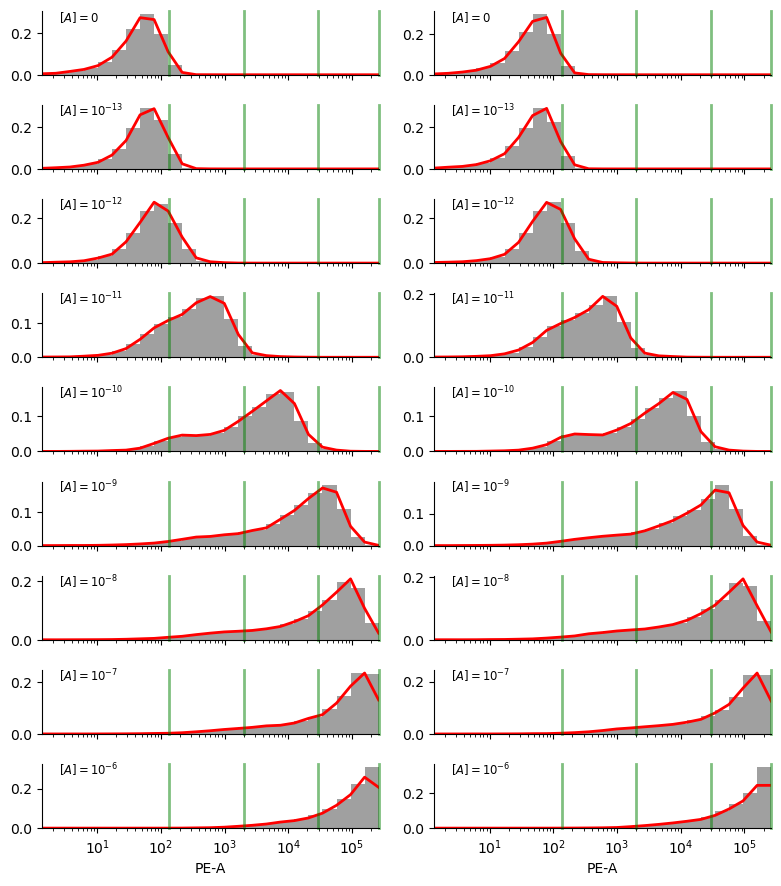

In [15]:
g = sns.displot(
    data=fcs_df.loc[(fcs_df["PE-A"] >= np.exp(logf_grid)[0]) & (fcs_df["PE-A"] <= np.exp(logf_grid)[-1])],
    x="PE-A",
    row="concentration",
    col="library",
    bins=np.exp(logf_grid),
    # bins=np.concatenate((np.linspace(fcs_df["PE-A"].min(), 0, 10), np.logspace(1, 6, 100))),
    # bins=fcs_df["PE-A"].min() + np.logspace(1, 6, 100),
    # stat="frequency",
    stat="probability",
    common_norm=False,
    color="gray",
    height=1, aspect=4,
    facet_kws=dict(sharey=False),
    )

g.set_ylabels("")
g.set_titles("")

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i, j].plot(np.exp(logf_grid),
                          (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :] / (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :].sum(),
                          color="r", lw=2)
        for bi in b[1:]:
            g.axes[i, j].axvline(bi, color="g", clip_on=False, alpha=0.5, lw=2)
            if g.row_names[i] > 0:
                power = int(np.log10(g.row_names[i]))
                title = f"$[A] = 10^{{{power}}}$"
            else:
                title = "$[A] = 0$"
            g.axes[i, j].set_title(title,
                        fontsize='small',
                        loc='left',
                        x=0.05,
                        y=0.7,
                        )

plt.xscale("log")
plt.xlim(np.exp(logf_grid[0]), np.exp(logf_grid[-1]))

plt.tight_layout()
plt.show()

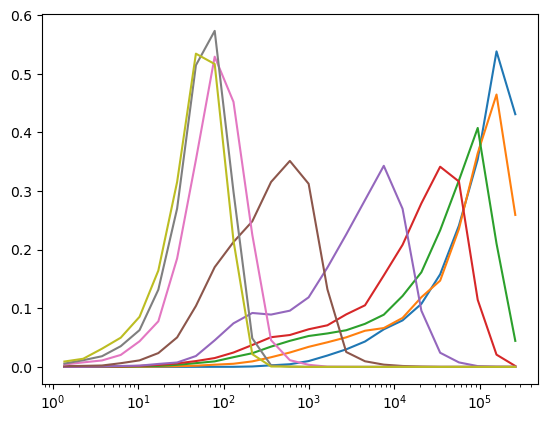

In [16]:
plt.plot(np.exp(logf_grid), logf_pdfs1.T)
plt.xscale("log")

In [17]:
fcs_df["PE-A"] < b[0]

0         False
1         False
2         False
3         False
4         False
          ...  
351067    False
351068    False
351069    False
351070    False
351071    False
Name: PE-A, Length: 351072, dtype: bool

In [18]:
meta, data = fcsparser.parse(fcs_file, reformat_meta=True)

spill_values = meta["SPILL"].split(',')
n = int(spill_values[0])  # The first item is the number of channels
spill_df = pd.DataFrame(np.array(spill_values[3:], dtype=np.float64).reshape((n, n)).T,
                        index=spill_values[1:3],
                        columns=spill_values[1:3])
spill_df


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


In [19]:
with pd.option_context("display.precision", 10):
    print("spillover matrix")
    display(spill_df)
    print("inverse spillover matrix")
    display(pd.DataFrame(np.linalg.inv(spill_df), index=spill_df.columns, columns=spill_df.columns))

spillover matrix


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


inverse spillover matrix


,PE-A,FITC-A
PE-A,1.0000255007,-0.0030000765
FITC-A,-0.0085002168,1.0000255007


Spillover matrix mixes two true signals into two observed signals:
$$
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
$$
So to recover the true signals from the observed signals, we invert the matrix:
$$
\begin{align*}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
&=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}\\
&=
\begin{pmatrix}
1.0000255007 & -0.0030000765 \\
-0.0085002168 & 1.0000255007 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
\end{align*}\\
$$

/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


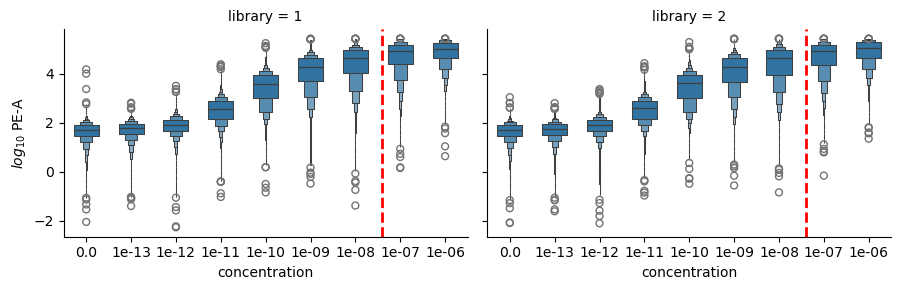

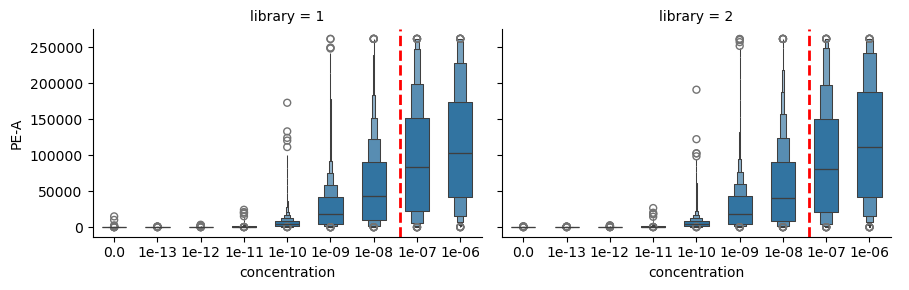

In [20]:
fcs_df["$log_{10}$ PE-A"] = np.log10(fcs_df["PE-A"])
for yval in ("$log_{10}$ PE-A", "PE-A"):
    g = sns.catplot(data=fcs_df,
                    kind="boxen",
                    col="library",
                    x="concentration",
                    y=yval,
                    gap=.3,
                    height=3, aspect=1.5,
                )
    g.refline(x=6 + np.log10(4), color="r", linestyle='--', lw=2, label="BLI naive $K_D$")
    # plt.yscale("symlog", linthresh=100, linscale=0.2)
    # plt.ylim(b[0], 1.1 * b[-1])
    plt.tight_layout()
    plt.show()

In [21]:
logf_pdfs1 = np.flip(logf_pdfs1, axis=0)
logf_pdfs2 = np.flip(logf_pdfs2, axis=0)

### Modeling functions

In [22]:
jax.devices()
# jax.device_put(x, device=None)

[CpuDevice(id=0)]

In [23]:
# NOTE: assumes logx[0] = -inf
def f(logx, logα, logβ, logKd, logn):
    n = jnp.exp(logn)  # Hill coefficient
    logx = jnp.atleast_1d(logx)[:, None]
    logα = jnp.atleast_1d(logα)[None, :]
    logKd = jnp.atleast_1d(logKd)[None, :]
    result = jnp.exp(logβ) * jnp.ones((logx.shape[0], logα.shape[-1]))
    result = result.at[1:].add(jnp.exp(logα) * jexpit(n * (logx[1:] - logKd))).squeeze()
    return result

# NOTE: this function assumes truncation on the high bin, so all counts above it are in that bin (infinite upper boundary)
def logp(logx, logα, logβ, logKd, b, logσ, logn):
    fs = f(logx, logα, logβ, logKd, logn)
    σ = jnp.exp(logσ)
    logcdf_points = jax.scipy.stats.norm.logcdf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    logsf_points = jax.scipy.stats.norm.logsf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    first = logcdf_points[:, 0, None]
    middle = jax.scipy.special.logsumexp(jnp.concatenate((logcdf_points[:, 1:, None], logcdf_points[:, 0:-1, None]),
                                                       axis=-1),
                                       b=jnp.array([1, -1]),
                                       axis=-1)
    # this accounts for the fact that the last bin includes all values above the last boundary
    last = logsf_points[:, -1, None]
    return jnp.concatenate((first, middle, last), axis=-1)     

def p(logx, logα, logβ, logKd, b, logσ, logn):
    return jnp.exp(logp(logx, logα, logβ, logKd, b, logσ, logn))

@jax.jit
def one_neg_log_likelihood(logγ, logα, logKd, y, logβ, logσ, logx, b, cells, reads_per_cell, logn):
    # We have a compound poisson distribution for the read count in each (concentration, bin)
    # We match moments to the negative binomial distribution
    logp_ = logp(logx, logα, logβ, logKd, b, logσ, logn)
    # expected cell count matrix
    λ_cell = cells[:, None] * jnp.exp(logγ + logp_[None, :])
    nbinom_logp = - jnp.log1p(reads_per_cell)
    
    ll = jax.scipy.special.gammaln(λ_cell + y) - jax.scipy.special.gammaln(λ_cell) + λ_cell * nbinom_logp

    return -ll.sum()

vmap_one_neg_log_likelihood = jax.vmap(one_neg_log_likelihood, in_axes=(0, 0, 0, 0, None, None, None, None, None, None, None))

@jax.jit
def DKL(params, data):
    logγs, logαs, logKds, logσ, logn = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    σ = jnp.exp(logσ)
    fs = f(logx, logαs, logβ, logKds, logn)
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    return jax.scipy.integrate.trapezoid(jax.scipy.special.kl_div(logf_pdfs, logf_pdfs_predicted), x=logf_grid, axis=1).sum()

@jax.jit
def neg_log_likelihood(params, data,
                       μ=0.0,  # prior matching weight
                       λ=0.0,  # Lagrange multiplier estimate for Augmented Lagrangian iterates
                       γ_ridge=0.0, α_ridge=0.0, Kd_ridge=0.0,
                       ):
    logγs, logαs, logKds, logσ, logn = params
    Y, wt_idx, logx, b, cells, reads_per_cell, logβ, logf_grid, logf_pdfs, single_mut_idxs, other_mut_idxs = data
    logγs = logγs * jnp.ones(Y.shape[0])
    logαs = logαs * jnp.ones(Y.shape[0])
    logKds = logKds * jnp.ones(Y.shape[0])
    
    nll = vmap_one_neg_log_likelihood(logγs, logαs, logKds, Y, logβ, logσ, logx, b, cells, reads_per_cell, logn).mean()

    D = DKL(params, data)
    prior_penalty = (μ / 2) * D ** 2 + λ * D

    logγ_penalty = γ_ridge * (((logγs[single_mut_idxs] - logγs[single_mut_idxs].mean()) ** 2).sum() + ((logγs[other_mut_idxs] - logγs[other_mut_idxs].mean()) ** 2).sum())
    # logα_nonwt_mean = (logαs.sum() - logαs[wt_idx]) / (len(logαs) - 1)
    # logα_penalty = α_ridge * (((logαs - logα_nonwt_mean) ** 2).sum() - ((logαs[wt_idx] - logα_nonwt_mean) ** 2).sum())
    # logKd_nonwt_mean = (logKds.sum() - logKds[wt_idx]) / (len(logKds) - 1)
    # logKd_penalty = Kd_ridge * (((logKds - logKd_nonwt_mean) ** 2).sum() - ((logKds[wt_idx] - logKd_nonwt_mean) ** 2).sum())
    logα_penalty = α_ridge * ((logαs - logαs[wt_idx]) ** 2).sum()
    logKd_penalty = Kd_ridge * ((logKds - logKds[wt_idx]) ** 2).sum()

    return nll + logγ_penalty + logα_penalty + logKd_penalty + prior_penalty


@jax.jit
def one_mean_bin_loss(logα, logKd, ynorm, logβ, logσ, logx, b, binfs,
                      ):
    mean_bin_dat = (ynorm * binfs).sum(1) / ynorm.sum(1)
    ps = p(logx, logα, logβ, logKd, b, logσ)
    mean_bin_model = (ps * binfs).sum(1) / ps.sum(1)
    w = jnp.log(ynorm.sum(-1, keepdims=True))
    # w = jnp.ones(Ynorm.shape[1])
    curve_fit_loss = (w * (mean_bin_model - mean_bin_dat) ** 2).sum()
    return curve_fit_loss

vmap_mean_bin_loss = jax.vmap(one_mean_bin_loss, in_axes=(0, 0, 0, None, None, None, None, None,
                                                          ))

@jax.jit
def mean_bin_loss(params, data,
                  prior_weight=0.0,
                #   L2_logα=0.0, L2_logKd=0.0,
                  ):
    logαs, logKds, logσ = params
    Ynorm, logx, b, binfs, logβ, logf_grid, logf_pdfs = data
    # Ynorm, logx, b, binfs, ref_idx = data
    logαs = logαs * jnp.ones(Ynorm.shape[0])
    logKds = logKds * jnp.ones(Ynorm.shape[0])

    curve_fit_loss = vmap_mean_bin_loss(logαs, logKds, Ynorm, logβ, logσ, logx, b, binfs,
                                        ).mean()
    # return curve_fit_loss
    # return (curve_fit_loss
    #         + L2_logα * ((logαs - logαs[ref_idx]) ** 2).mean()
    #         + L2_logKd * ((logKds - logKds[ref_idx]) ** 2).mean()
    #         )
    σ = jnp.exp(logσ)
    fs = f(logx, logαs, logβ, logKds)
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    logf_pdfs_predicted = logf_pdfs_predicted / jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1)[:, None]
    # plt.plot(logf_grid, logf_pdfs.T, c="C0")
    # plt.plot(logf_grid, logf_pdfs_predicted.T, c="C1")
    # plt.show()
    # print(jax.scipy.integrate.trapezoid(logf_pdfs, x=logf_grid, axis=1))
    # print(jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1))
    prior_loss = jax.scipy.integrate.trapezoid((logf_pdfs_predicted - logf_pdfs) ** 2, x=logf_grid, axis=1).sum()

    return curve_fit_loss + prior_weight * prior_loss


Read and cell count data

In [24]:
R_df = df_variants.rename(columns={"antigen_concentration": "concentration",
                                   "read_count": "number_reads"}).groupby(["library", "concentration", "bin"]).number_reads.sum().sort_index()
C_df = barcode_runs.reset_index().rename(columns={"sort_bin": "bin"}).set_index(["library", "concentration", "bin"]).number_cells.sort_index()
assert C_df.index.equals(R_df.index)

counts_df = pd.concat((R_df, C_df), axis=1, verify_integrity=True)

counts_df

number_reads  number_cells
library concentration bin                            
lib1    0.000000e+00  1        10641738       4994518
                      2          100855         97766
                      3             244           156
                      4              38            57
        1.000000e-13  1         1891730       4879499
...                                 ...           ...
lib2    1.000000e-07  4         6067003       3595640
        1.000000e-06  1            1599          5023
                      2          138321         85666
                      3         1720726        910355
                      4         5059461       4087566

[72 rows x 2 columns]

Jax data from pandas frames

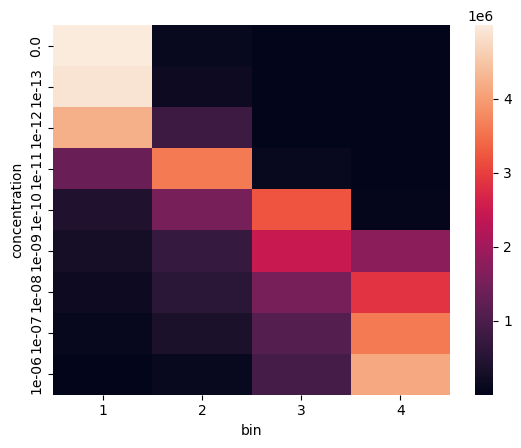

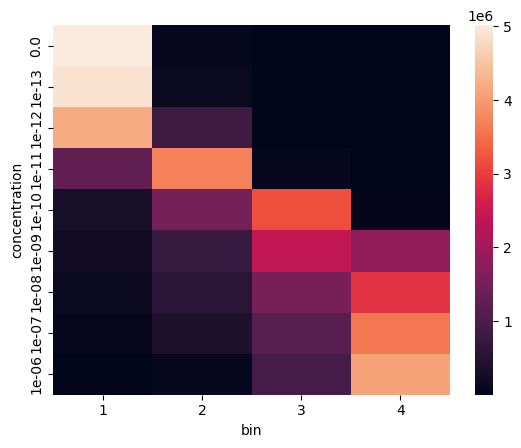

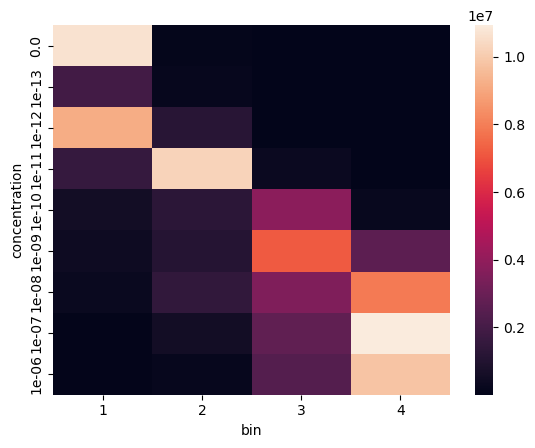

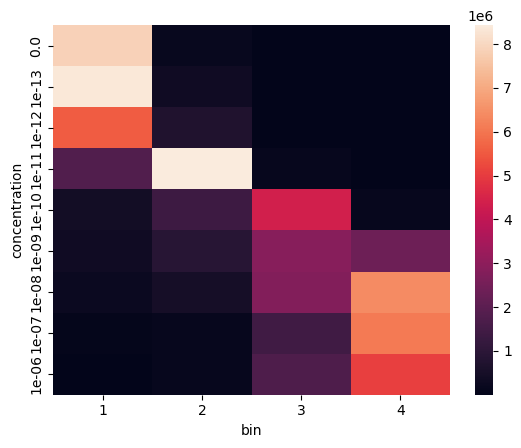

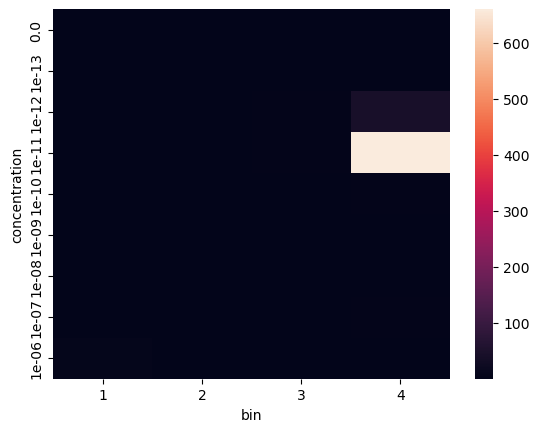

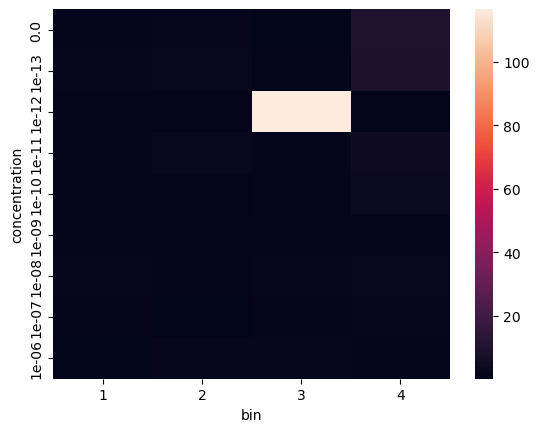

In [25]:
cells1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")
cells2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_cells")

reads1 = counts_df.loc["lib1"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")
reads2 = counts_df.loc["lib2"].reset_index().pivot(index="concentration", columns="bin", values="number_reads")

reads_per_cell1 = reads1 / cells1
reads_per_cell2 = reads2 / cells2

sns.heatmap(cells1)
plt.show()
sns.heatmap(cells2)
plt.show()

sns.heatmap(reads1)
plt.show()
sns.heatmap(reads2)
plt.show()

sns.heatmap(reads_per_cell1)
plt.show()
sns.heatmap(reads_per_cell2)
plt.show()

In [26]:
x = np.flip(concs)
logx = np.log(x)
libs = []
variants = []
variant_types = []
n_aa_substitutions = []
Y = []
bcs = []
Ynorm = []
for idx, ((lib, variant, n_aa_substitution), group_df) in enumerate(df_variants.groupby(["library", "variant", "n_aa_substitutions"])):
    y = group_df.read_count.values.reshape(len(x), -1)
    ynorm = group_df.estimated_cell_count.values.reshape(len(x), -1)
    libs.append(lib)
    variants.append(variant)
    if "*" in variant:
        variant_types.append("nonsense")
    elif variant != "WT":
        if n_aa_substitution == 1:
            variant_types.append(f"1 missense")
        elif n_aa_substitution > 1:
            variant_types.append(f">1 missense")
        else:
            raise ValueError
    else:
        variant_types.append("WT")
    n_aa_substitutions.append(n_aa_substitution)
    Y.append(y)
    assert len(group_df.barcode.unique()) == 1, group_df.barcode
    bcs.append(float(group_df.barcode.unique().squeeze()))
    Ynorm.append(ynorm)
libs = np.array(libs)
variants = np.array(variants)
variant_types = np.array(variant_types)
n_aa_substitutions = np.array(n_aa_substitutions)
Y = np.array(Y)
bcs = np.array(bcs)
Ynorm = np.array(Ynorm)

assert Y.shape == Ynorm.shape

Y.shape

/tmp/ipykernel_562/3065504854.py:2: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)


(19637, 9, 4)

Distribution of normalized read counts per variant

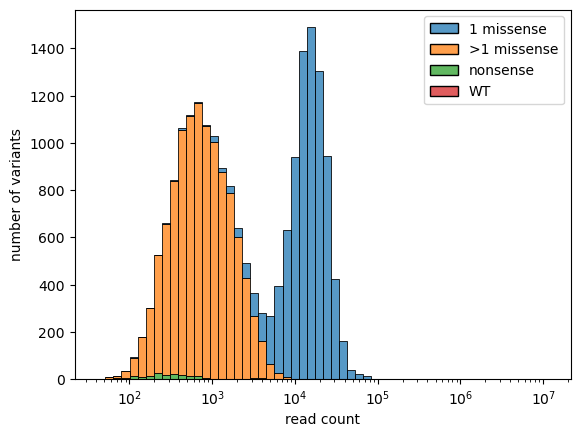

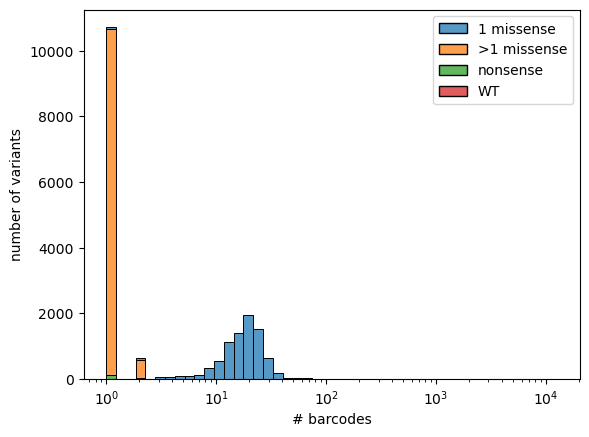

In [27]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

Filter variants with low read counts

In [28]:
# filter_idxs = (n_aa_substitutions <= 1) & (Y.sum(-1) >= 10).all(-1) & (variant_types != "nonsense")
# filter_idxs = (n_aa_substitutions <= 1) & (Y.sum((1, 2)) >= 1000) & (variant_types != "nonsense")
filter_idxs = (Y.sum((1, 2)) >= 100)
Y = Y[filter_idxs]
Ynorm = Ynorm[filter_idxs]
libs = libs[filter_idxs]
variants = variants[filter_idxs]
variant_types = variant_types[filter_idxs]
n_aa_substitutions = n_aa_substitutions[filter_idxs]
bcs = bcs[filter_idxs]

Y.shape

(19579, 9, 4)

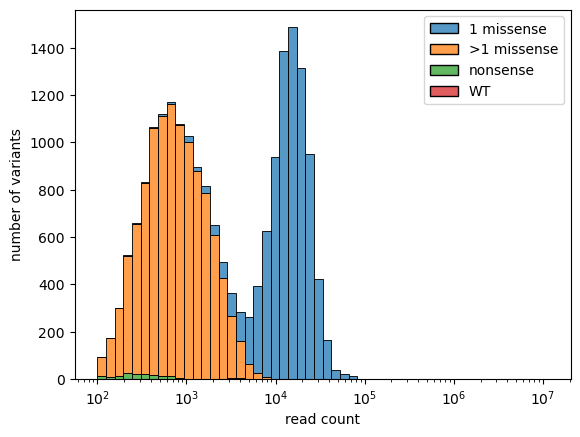

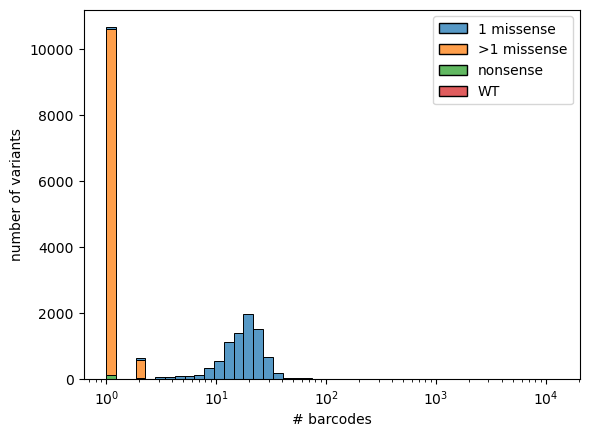

In [29]:
sns.histplot(x=Y.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

indices of WT

In [30]:
wt_idx1, wt_idx2 = np.where(variants == "WT")[0]

libs[wt_idx1], variants[wt_idx1], libs[wt_idx2], variants[wt_idx2]

('lib1', 'WT', 'lib2', 'WT')

indices of libraries

In [31]:
lib1_idxs = np.where(libs == "lib1")[0]
lib2_idxs = np.where(libs == "lib2")[0]

Initialize parameters

In [32]:
def binfs_fn(df):
    result = pd.Series([np.log(df["PE-A"].loc[df["PE-A"] < b[1]]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[1]) & (df["PE-A"] < b[2])]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[2]) & (df["PE-A"] < b[3])]).mean(),
            np.log(df["PE-A"].loc[df["PE-A"] >= b[3]]).mean()],
            index=bins,
    )
    if pd.isna(result[1]):
        result[1] = np.log(b[1] / 2)
    if pd.isna(result[2]):
        result[2] = np.log(b[1] + (b[2] - b[1]) / 2)
    if pd.isna(result[3]):
        result[3] = np.log(b[2] + (b[3] - b[2]) / 2)
    if pd.isna(result[4]):
        result[4] = np.log(b[3] + (b[4] - b[3]) / 2)
    return result

binfs1 = fcs_df.query("library == 1").groupby("concentration").apply(binfs_fn).values
binfs2 = fcs_df.query("library == 2").groupby("concentration").apply(binfs_fn).values
binfs1, binfs2

/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_562/2353376163.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binfs1 = fcs_df.query("library == 1").groupby("concentration").apply(binfs_fn).values
/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_562/2353376163.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depre

(array([[ 3.67535567,  5.1029518 ,  8.84928666, 11.88986763],
        [ 3.8027649 ,  5.1255578 ,  9.66208456, 11.88986763],
        [ 3.96695796,  5.30006393,  7.83393444, 11.88986763],
        [ 4.05794371,  6.20638973,  8.06921064, 11.88986763],
        [ 4.21443269,  6.43628639,  8.79475605, 10.65593872],
        [ 3.94763998,  6.44813809,  9.27926545, 10.86366992],
        [ 3.96291979,  6.51484936,  9.23536877, 11.27990724],
        [ 4.02359372,  6.66549913,  9.19591443, 11.62314663],
        [ 3.56925577,  7.00021358,  9.3050182 , 11.68026997]]),
 array([[ 3.70144604,  5.10336554,  9.66208456, 11.88986763],
        [ 3.74420994,  5.12493838,  9.66208456, 11.88986763],
        [ 3.97271008,  5.27766209,  7.74602864, 11.88986763],
        [ 4.08805716,  6.20576978,  8.07307964, 11.88986763],
        [ 4.25937259,  6.39374475,  8.83492159, 10.65256475],
        [ 3.97367315,  6.43588833,  9.22710318, 10.87296893],
        [ 3.95195404,  6.52715668,  9.21514817, 11.30047172],
      

In [33]:
def mean_bin_fn(df):
    library = df.library.unique().squeeze()
    if library == "lib1":
        binfs = binfs1
    elif library == "lib2":
        binfs = binfs2
    else:
        raise ValueError(library)
    concentration = df.antigen_concentration.unique().squeeze()
    concentration_idx = np.where(x == concentration)[0].squeeze()
    return np.exp(np.average(binfs[concentration_idx], weights=df.estimated_cell_count))

mean_bin_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})
mean_bin_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})

display(mean_bin_barcodes)
display(mean_bin_variants)

/tmp/ipykernel_562/1802425166.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_bin_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})
/tmp/ipykernel_562/1802425166.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_bin_variants = df_variants.

,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin_based_fluorescence
0,lib1,A104C,1,AAAACACTATCTAGGA,0.000000e+00,41.120160
1,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-13,44.824950
2,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-12,57.853982
3,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-11,525.080754
4,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-10,4709.793081
...,...,...,...,...,...,...
1398109,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-10,598.092095
1398110,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-09,14571.907049
1398111,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-08,23843.684991
1398112,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-07,51924.784913


,library,variant,n_aa_substitutions,antigen_concentration,bin_based_fluorescence
0,lib1,A104C,1,0.000000e+00,40.549972
1,lib1,A104C,1,1.000000e-13,46.202329
2,lib1,A104C,1,1.000000e-12,64.506551
3,lib1,A104C,1,1.000000e-11,437.484952
4,lib1,A104C,1,1.000000e-10,5152.052021
...,...,...,...,...,...
176728,lib2,Y94W R145M,2,1.000000e-10,598.092095
176729,lib2,Y94W R145M,2,1.000000e-09,14571.907049
176730,lib2,Y94W R145M,2,1.000000e-08,23843.684991
176731,lib2,Y94W R145M,2,1.000000e-07,51924.784913


/tmp/ipykernel_562/3486895865.py:11: RuntimeWarning: divide by zero encountered in log
  logx_grid = np.log(x_grid)
/tmp/ipykernel_562/3486895865.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(b[0], b[-1])


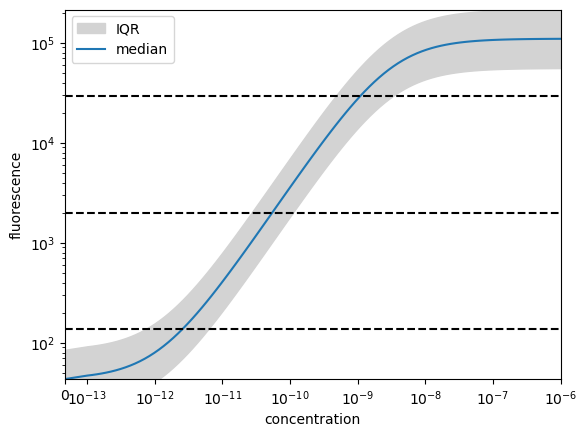

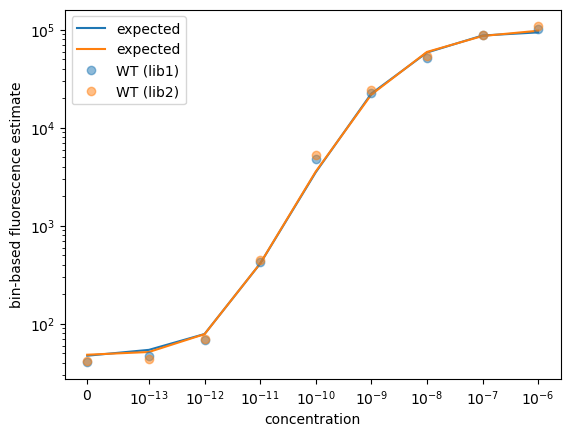

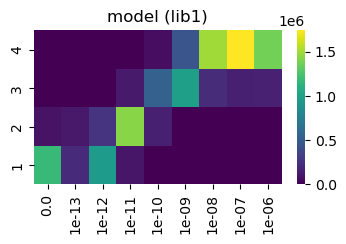

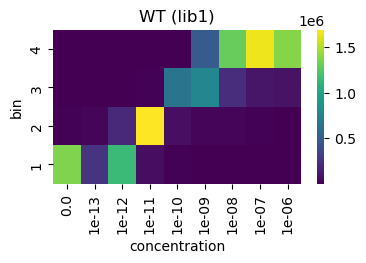

In [34]:
logα = np.log(1.1e5)
logKd = np.log(3e-9)
logσ = 0.0
logn = 0.0

logβ = np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].median())

logγ = np.log(bcs[wt_idx1] / bcs[lib1_idxs].sum())

x_grid = np.array([0] + list(np.logspace(np.log10(x[1]), np.log10(x[-1]), 100)))
logx_grid = np.log(x_grid)
fs = f(logx_grid, logα, logβ, logKd, logn)
scale = np.exp(logσ)
q25 = scipy.stats.lognorm.ppf(0.25, s=scale, scale=fs)
q75 = scipy.stats.lognorm.ppf(0.75, s=scale, scale=fs)
plt.fill_between(x_grid,
                 q25,
                 q75,
                 color="lightgray",
                 label="IQR")
plt.plot(x_grid, fs, label="median")
for b_ in b:
    plt.axhline(b_, color="k", linestyle="--")
plt.xscale("symlog", linthresh=x[1], linscale=0.3)
plt.yscale("log")
plt.ylim(b[0], b[-1])
plt.xlabel("concentration")
plt.ylabel("fluorescence")
plt.xlim(x[0], x[-1])
plt.ylim(fs[0], q75[-1])
plt.legend()
plt.show()

ps = p(logx, logα, logβ, logKd, b, logσ, logn)
mean_binf1 = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf2 = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt1 = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
mean_binf_wt2 = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))

plt.plot(x, mean_binf1, label="expected", c="C0")
plt.plot(x, mean_binf2, label="expected", c="C1")
plt.plot(x, mean_binf_wt1, "o", label="WT (lib1)", alpha=0.5, c="C0")
plt.plot(x, mean_binf_wt2, "o", label="WT (lib2)", alpha=0.5, c="C1")
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

logps = logp(logx, logα, logβ, logKd, b, logσ, logn)

# expected read count matrix
exp_cell_df = pd.DataFrame((reads_per_cell1 * cells1.values.sum(1, keepdims=True) * np.exp(logγ + logps)).T, columns=x, index=bins)
plt.figure(figsize=(4, 2))
ax = sns.heatmap(exp_cell_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"model (lib1)")
plt.show()

read_df = pd.DataFrame(Y[wt_idx1].T, columns=pd.Series(x, name="concentration"), index=pd.Series(bins, name="bin"))
plt.figure(figsize=(4, 2))
ax = sns.heatmap(read_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"WT (lib1)")
plt.show()

Loss surface for WT

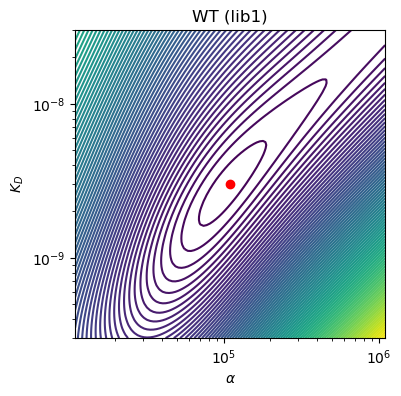

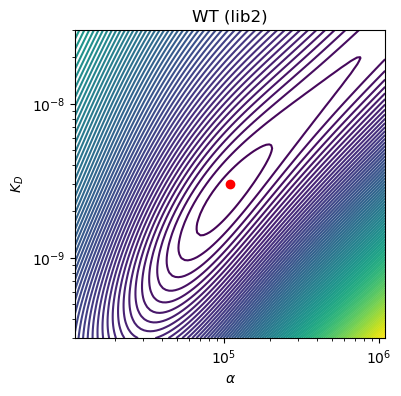

In [35]:
for ct, (wt_idx, logf_pdfs, binfs) in enumerate(zip((wt_idx1, wt_idx2),
                                                    (logf_pdfs1, logf_pdfs2),
                                                    (binfs1, binfs2)),
                                                          1):
    # plot loss surface for Kd and α on one sample
    αs = np.exp(logα) * np.logspace(-1, 1, 100)
    Kds = np.exp(logKd) * np.logspace(-1, 1, 100)
    # αs, Kds = np.meshgrid(αs, Kds)
    loss = np.zeros((Kds.shape[0], αs.shape[0]))
    for i in range(Kds.shape[0]):
        for j in range(αs.shape[0]):
            # loss[i, j] = one_neg_log_likelihood(np.log(αs[j]), np.log(Kds[i]), Y[wt_idx], bcs[wt_idx], logλ, logφ, logβ, logσ, logx, b)
            
            # neg_log_likelihood((logβ, logσ, jnp.array([np.log(αs[j])]), jnp.array([np.log(Kds[i])]), logλ, logφ),
                                            # (jnp.array([Y[wt_idx]]), logx, b))    
            # loss[i, j] = one_mean_bin_loss(np.log(αs[j]), np.log(Kds[i]), Ynorm[wt_idx],
            #                                logβ, logσ, logx, b, binfs,
            #                                )
            loss[i, j] = one_neg_log_likelihood(logγ, np.log(αs[j]), np.log(Kds[i]), Y[wt_idx],
                                                logβ, logσ, logx, b, cells1.values, reads_per_cell1.values, logn)

    plt.figure(figsize=(4, 4))
    plt.contour(αs, Kds, loss, levels=100)
    plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
    plt.xlabel("$\\alpha$")
    plt.ylabel("$K_D$")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"WT (lib{ct})")
    plt.show()

Form data and params for optimizations

In [36]:
single_mut_idxs = (n_aa_substitutions == 1) & (variant_types != "nonsense")
other_mut_idxs = (n_aa_substitutions > 1) | (variant_types == "nonsense")

assert sum(single_mut_idxs) + sum(other_mut_idxs) == len(n_aa_substitutions) - 2

In [37]:
data1 = Y[lib1_idxs], wt_idx1, logx, b, cells1.values.sum(1), reads_per_cell1.values, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs1, np.where(single_mut_idxs[lib1_idxs])[0], np.where(other_mut_idxs[lib1_idxs])[0]
data2 = Y[lib2_idxs], wt_idx2 - len(lib1_idxs), logx, b, cells2.values.sum(1), reads_per_cell2.values, np.log(fcs_df.query("library == 2 & concentration == 0")["PE-A"]).median(), logf_grid, logf_pdfs2, np.where(single_mut_idxs[lib2_idxs])[0], np.where(other_mut_idxs[lib2_idxs])[0]

# data1 = Ynorm[lib1_idxs], logx, b, binfs1, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs1
# data2 = Ynorm[lib2_idxs], logx, b, binfs2, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs2
# data1 = Ynorm[lib1_idxs], logx, b, binfs1, wt_idx1
# data2 = Ynorm[lib2_idxs], logx, b, binfs2, wt_idx2 - len(lib1_idxs)

# data1 = (Y[lib1_idxs], bcs[lib1_idxs], logx, b)
# data2 = (Y[lib2_idxs], bcs[lib2_idxs], logx, b)

/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
# # αs, Kds
# @jax.jit
# @jax.value_and_grad
# def loss_block1(αKd, params, data, **kwargs):
#     params[:2] = αKd
#     return mean_bin_loss(params, data, **kwargs)

# # σ
# @jax.jit
# @jax.value_and_grad
# def loss_block2(σ, params, data, **kwargs):
#     params[2] = σ
#     return mean_bin_loss(params, data, **kwargs)

$$
p(z\mid \alpha, \beta, K_D, \sigma^2)
$$

$$
\begin{align*}
p(\alpha, \beta, \gamma, \kappa, \sigma, Z, Y) &= p(\alpha, \beta, \gamma, \kappa, \sigma \mid Z, Y) \ p(Z, Y)\\
&= p(\alpha, \beta, \gamma, \kappa, \sigma \mid z, y) \ p(Y \mid Z) p(Z)
\end{align*}
$$

In [39]:
opt = jaxopt.ScipyBoundedMinimize(
    fun=neg_log_likelihood,
    method="l-bfgs-b",
    # projection=jaxopt.projection.projection_box,
    # value_and_grad=True,
    maxiter=1000, tol=1e-12,
    options=dict(maxls=100,
                 maxcor=10000,
                #  ftol=0,
                #  gtol=0,
                #  iprint=1,
                # disp=True,
                 ),
    # acceleration=False,
    # linesearch="zoom",
    # maxls=50,
    # linesearch_init="max",
    # stepsize=0.01,
    # max_stepsize=1e2, min_stepsize=1e-4,
    # history_size=100,
    # verbose=True,
    jit=True,
)

In [40]:
params1 = [jnp.log(bcs[lib1_idxs] / bcs[lib1_idxs].sum()),
           logα * jnp.ones(len(lib1_idxs)),
           logKd * jnp.ones(len(lib1_idxs)),
           jnp.asarray(logσ),
           jnp.asarray(logn),
           ]
params2 = [jnp.log(bcs[lib2_idxs] / bcs[lib2_idxs].sum()),
           logα * jnp.ones(len(lib2_idxs)),
           logKd * jnp.ones(len(lib2_idxs)),
           jnp.asarray(logσ),
           jnp.asarray(logn),
           ]

In [41]:
def bounds(params):
    lb = [
          jnp.full_like(params[0], -20),
          jnp.full_like(params[1], logα - 6),
          jnp.full_like(params[2], jnp.log(1e-12)),
          jnp.array(-0.75),
          jnp.array(-1.0),
          ]
    ub = [
          jnp.full_like(params[0], 0),
          jnp.full_like(params[1], logα + 6),
          jnp.full_like(params[2], jnp.log(1e-4)),
          jnp.array(0.75),
          jnp.array(1.0),
          ]
    return lb, ub

In [42]:
jax.grad(neg_log_likelihood)(params1, data1)

[Array([ 0.13816871,  0.02850895,  0.03533426, ..., -0.02228648,
        -0.0103629 ,  0.01202642], dtype=float64),
 Array([ 0.0151652 ,  0.00826157, -0.00045882, ...,  0.01568604,
        -0.00298781,  0.23825447], dtype=float64),
 Array([-0.01481091, -0.00454293, -0.00091674, ..., -0.01073402,
         0.00330559, -0.17343848], dtype=float64),
 Array(27.67494678, dtype=float64, weak_type=True),
 Array(-1030.81872362, dtype=float64, weak_type=True)]

In [43]:
γ_ridge = 1e-2
α_ridge = 1e-3
Kd_ridge = 1e-3

λ1 = 1e-3
λ2 = 1e-3
for μ in np.logspace(-2, 2, 10):
# for μ in (0,):
    print(f"{μ=:.1e}")

    print(f"  {λ1=:.1e}")
    params1, state1 = opt.run(
        params1,
        bounds(params1),
        data1,
        μ=μ, λ=λ1,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D1 = DKL(params1, data1)
    λ1 += μ * D1
    error1 = opt.l2_optimality_error(params1,
                                     bounds(params1),
                                     data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj1 = neg_log_likelihood(params1, data1, μ=μ, λ=λ1, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state1.iter_num} iterations, success={state1.success}")
    print(f"    error={error1:.2e}")
    print(f"    obj={obj1:.2e}")
    print(f"    DKL={D1:.2e}")

    print(f"  {λ2=:.1e}")
    params2, state2 = opt.run(
        params2,
        bounds(params2),
        data2,
        μ=μ, λ=λ2,
        γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge,
        )
    D2 = DKL(params2, data2)
    λ2 += μ * D2
    error2 = opt.l2_optimality_error(params2,
                                     bounds(params2),
                                     data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    obj2 = neg_log_likelihood(params2, data2, μ=μ, λ=λ2, γ_ridge=γ_ridge, α_ridge=α_ridge, Kd_ridge=Kd_ridge)
    print(f"    {state2.iter_num} iterations, success={state2.success}")
    print(f"    error={error2:.2e}")
    print(f"    obj={obj2:.2e}")
    print(f"    DKL={D2:.2e}")

μ=1.0e-02
  λ1=1.0e-03
    687 iterations, success=True
    error=3.44e-02
    obj=-7.23e+04
    DKL=1.12e+00
  λ2=1.0e-03
    632 iterations, success=True
    error=6.84e-02
    obj=-5.03e+04
    DKL=1.64e+00
μ=2.8e-02
  λ1=1.2e-02
    4 iterations, success=True
    error=9.85e-02
    obj=-7.23e+04
    DKL=1.12e+00
  λ2=1.7e-02
    93 iterations, success=True
    error=1.91e-01
    obj=-5.03e+04
    DKL=1.64e+00
μ=7.7e-02
  λ1=4.3e-02
    5 iterations, success=True
    error=2.88e-01
    obj=-7.23e+04
    DKL=1.12e+00
  λ2=6.3e-02
    227 iterations, success=True
    error=5.20e-01
    obj=-5.03e+04
    DKL=1.63e+00
μ=2.2e-01
  λ1=1.3e-01
    206 iterations, success=True
    error=7.47e-01
    obj=-7.23e+04
    DKL=1.11e+00
  λ2=1.9e-01
    306 iterations, success=True
    error=1.40e+00
    obj=-5.03e+04
    DKL=1.60e+00
μ=6.0e-01
  λ1=3.7e-01
    316 iterations, success=True
    error=1.44e+00
    obj=-7.23e+04
    DKL=1.09e+00
  λ2=5.3e-01
    604 iterations, success=True
    error

In [44]:
params1, params2

([Array([ -8.36895837, -12.01661392, -12.09712935, ..., -10.85206155,
         -11.26536013,  -7.86783642], dtype=float64),
  Array([11.35283884, 11.79700431, 12.04027343, ..., 11.24768529,
         11.80020942, 11.11931622], dtype=float64),
  Array([-19.97794819, -19.69326495, -19.86408916, ..., -18.57721031,
         -20.10650148, -19.51914228], dtype=float64),
  Array(-0.25092519, dtype=float64),
  Array(0.01472761, dtype=float64)],
 [Array([ -8.73427795,  -8.02446985, -12.10193834, ..., -11.4918479 ,
          -7.43607929, -11.95661128], dtype=float64),
  Array([11.3904871 , 11.22430631, 12.06494086, ..., 12.11543067,
         11.11469337, 11.88793382], dtype=float64),
  Array([-19.98240674, -19.63348419, -19.91385858, ..., -20.38111644,
         -19.6665567 , -19.95148386], dtype=float64),
  Array(-0.29164811, dtype=float64),
  Array(0.02334641, dtype=float64)])

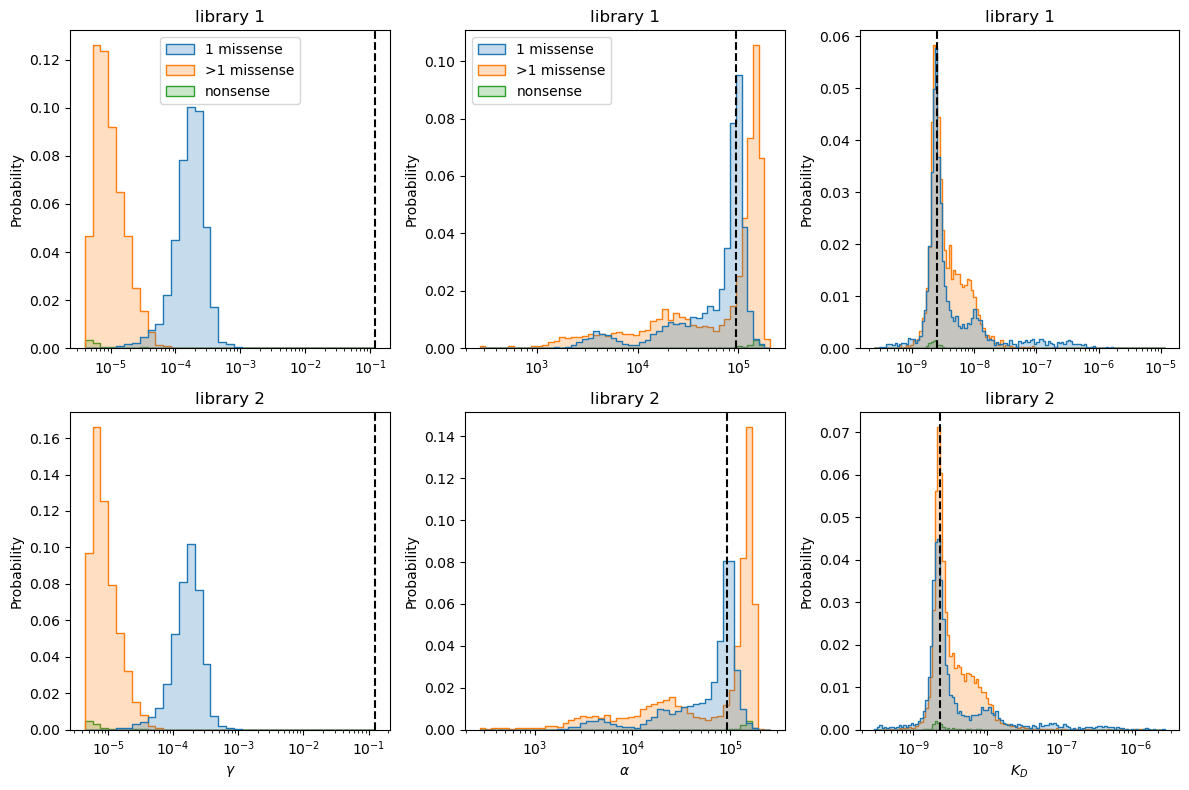

In [45]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
sns.histplot(x=np.exp(params1[0]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[0][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(234)
sns.histplot(x=np.exp(params2[0]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[0][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\gamma$")
plt.subplot(232)
sns.histplot(x=np.exp(params1[1]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[1][wt_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(235)
sns.histplot(x=np.exp(params2[1]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(2, 6, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[1][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\alpha$")
plt.subplot(233)
sns.histplot(x=np.exp(params1[2]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.title("library 1")
plt.axvline(np.exp(params1[2][wt_idx1]), color="k", linestyle="--")
plt.subplot(236)
sns.histplot(x=np.exp(params2[2]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
            #  bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[2][wt_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$K_D$")
plt.tight_layout()
plt.show()

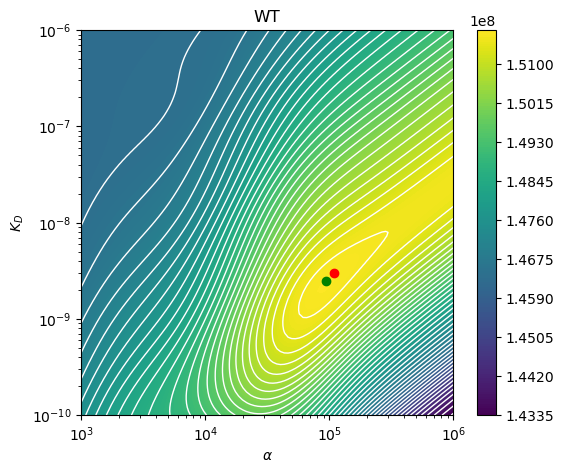

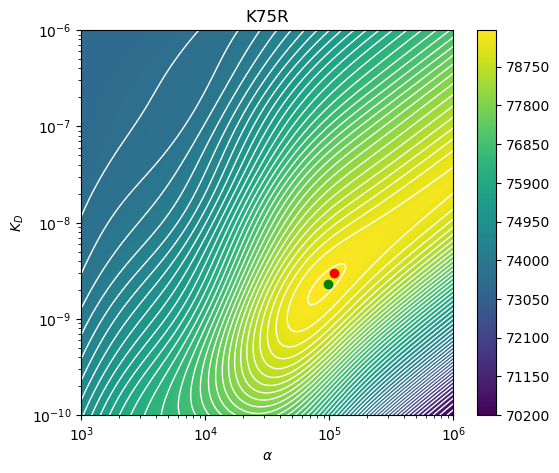

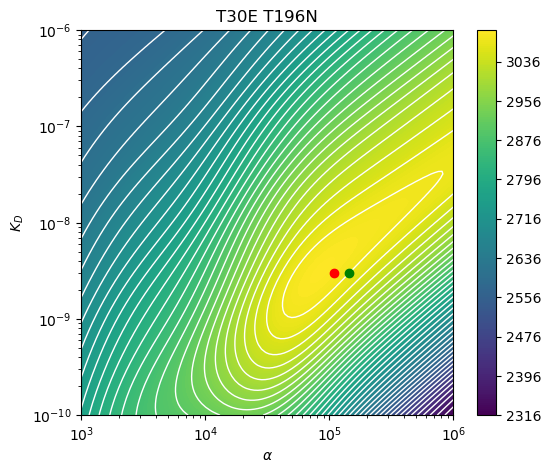

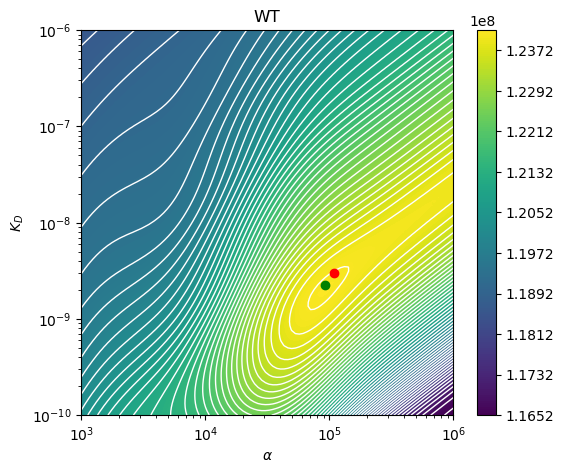

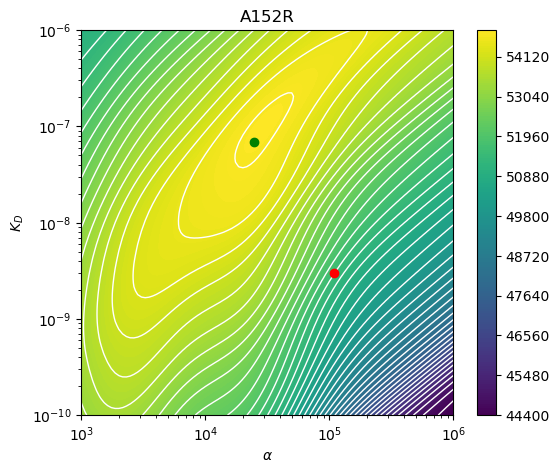

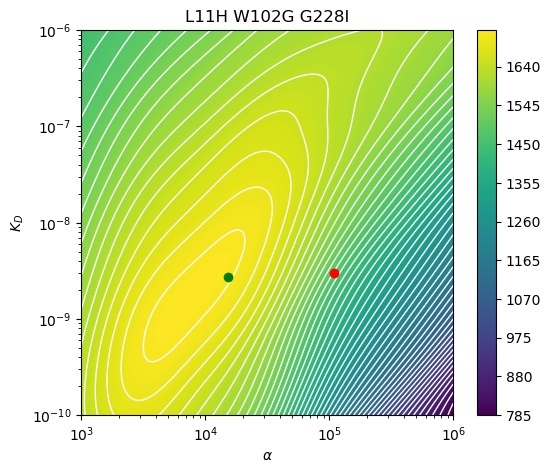

In [46]:
for datai, paramsi, wt_idxi, variantsi, variant_typesi in zip((data1, data2),
                                      (params1, params2),
                                      (wt_idx1, wt_idx2 - len(lib1_idxs)),
                                      (variants[lib1_idxs], variants[lib2_idxs]),
                                      (variant_types[lib1_idxs], variant_types[lib2_idxs]),
                                      ):
    Yi = datai[0].copy()
    logβi = datai[6]
    logγi = paramsi[0].copy()
    logσi = paramsi[3]
    logni = paramsi[4].copy()
    cellsi = datai[4].copy()
    reads_per_celli = datai[5].copy()
    αs = np.logspace(3, 6, 100)
    Kds = np.logspace(-10, -6, 100)
    for var_idx in (wt_idxi,
                    np.random.choice(np.where(variant_typesi == "1 missense")[0], 1)[0],
                    np.random.choice(np.where(variant_typesi == ">1 missense")[0], 1)[0]):
    # for var_idx in (wt_idxi, np.random.choice(np.where(variantsi == "F198N")[0], 1)[0]):
        # plot loss surface for Kd and α on one sample
        # αs, Kds = np.meshgrid(αs, Kds)
        loss = np.zeros((Kds.shape[0], αs.shape[0]))
        for i in range(Kds.shape[0]):
            for j in range(αs.shape[0]):
                # loss[i, j] = neg_log_likelihood((logβ, logσ, logγ, logφ, np.log(αs[j]), np.log(Kds[i]), logλs[0]),
                #                                (y, logx, b))        
                loss[i, j] = -one_neg_log_likelihood(logγi[var_idx], np.log(αs[j]), np.log(Kds[i]), Yi[var_idx],
                                                    logβi, logσi, logx, b, cellsi, reads_per_celli, logni)


        plt.figure(figsize=(6, 5))
        plt.contourf(αs, Kds, loss, levels=200, alpha=1.0)
        plt.colorbar()
        plt.contour(αs, Kds, loss, levels=50, linestyles="solid", linewidths=1, colors="w")
        plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
        plt.plot(np.exp(paramsi[1][var_idx]), np.exp(paramsi[2][var_idx]), "o", color="g")
        plt.xlabel("$\\alpha$")
        plt.ylabel("$K_D$")
        plt.xscale("log")
        plt.yscale("log")
        plt.title(variantsi[var_idx])
        plt.show()

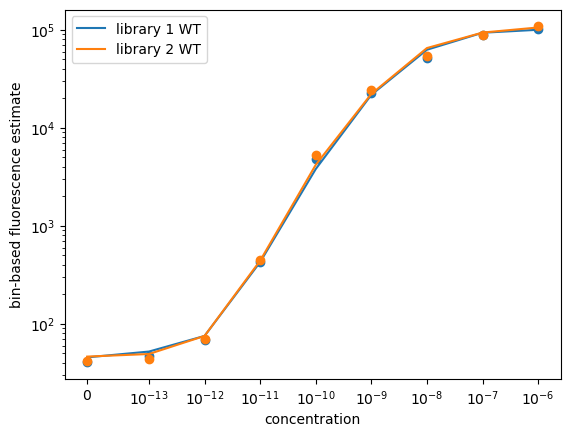

In [47]:
ps = p(logx, params1[1][wt_idx1], data1[6], params1[2][wt_idx1], b, params1[3], params1[4])
mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs1 * Ynorm[wt_idx1]).sum(1) / Ynorm[wt_idx1].sum(1))
plt.plot(x, mean_binf, c="C0", label="library 1 WT")
plt.plot(x, mean_binf_wt, "o", c="C0")
ps = p(logx, params2[1][wt_idx2 - len(lib1_idxs)], data2[6], params2[2][wt_idx2 - len(lib1_idxs)], b, params2[3], params2[4])
mean_binf = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs2 * Ynorm[wt_idx2]).sum(1) / Ynorm[wt_idx2].sum(1))
plt.plot(x, mean_binf, c="C1", label="library 2 WT")
plt.plot(x, mean_binf_wt, "o", c="C1")
""
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

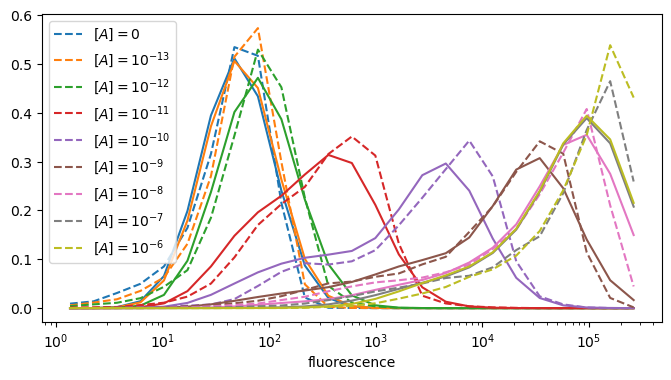

In [48]:
plt.figure(figsize=(8, 4))
for i, fs in enumerate(f(logx, params1[1], data1[6], params1[2], params1[4])):
    curve = scipy.stats.norm.pdf(logf_grid, loc=jnp.log(fs[:, None]), scale=np.exp(params1[3])).mean(0)
    curve = curve / jax.scipy.integrate.trapezoid(curve, x=logf_grid)
    plt.plot(np.exp(logf_grid), curve, c=f"C{i}")
    if i == 0:
        label = "$[A]=0$"
    else:
        label = f"$[A]=10^{{{int(np.log10(x[i])):1d}}}$"
    plt.plot(np.exp(logf_grid), logf_pdfs1[i], c=f"C{i}", ls="--", label=label)
plt.xscale("log")
plt.xlabel("fluorescence")
plt.legend()
plt.show()

In [49]:
variant_params_df = pd.DataFrame({"library": libs,
                            "variant": variants,
                            "n_aa_substitutions": n_aa_substitutions,
                            "variant_type": variant_types,
                            })
variant_params_df.loc[lib1_idxs, "log10fraction"] = np.asarray(params1[0]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10fraction"] = np.asarray(params2[0]) / np.log(10)
variant_params_df.loc[lib1_idxs, "log10expression"] = np.asarray(params1[1]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10expression"] = np.asarray(params2[1]) / np.log(10)
variant_params_df.loc[lib1_idxs, "log10Kd"] = np.array(params1[2]) / np.log(10)
variant_params_df.loc[lib2_idxs, "log10Kd"] = np.array(params2[2]) / np.log(10)

for lib in ("lib1", "lib2"):
    variant_params_df.loc[variant_params_df.library==lib, f"delta_log10Ka"] = variant_params_df.loc[(variant_params_df.library==lib) & (variant_params_df.variant=="WT"), "log10Kd"].squeeze() - variant_params_df.loc[variant_params_df.library==lib, "log10Kd"]

variant_params_df

,library,variant,n_aa_substitutions,variant_type,log10fraction,log10expression,log10Kd,delta_log10Ka
0,lib1,A104C,1,1 missense,-3.634592,4.930475,-8.676313,0.073830
1,lib1,A104C A173E,2,>1 missense,-5.218749,5.123374,-8.552676,-0.049806
2,lib1,A104C F137L,2,>1 missense,-5.253717,5.229024,-8.626864,0.024382
3,lib1,A104C G105V,2,>1 missense,-4.781183,4.391433,-7.912969,-0.689514
4,lib1,A104C G118S,2,>1 missense,-5.207449,5.176415,-8.631564,0.029081
...,...,...,...,...,...,...,...,...
19574,lib2,Y94V,1,1 missense,-3.445384,5.005057,-9.171633,0.524733
19575,lib2,Y94V G113C,2,>1 missense,-4.769222,5.117825,-8.821000,0.174100
19576,lib2,Y94V S112G,2,>1 missense,-4.990846,5.261665,-8.851406,0.204506
19577,lib2,Y94W,1,1 missense,-3.229448,4.827050,-8.541077,-0.105823


In [50]:
variant_params_df.query("variant == 'WT'").log10Kd

8712    -8.602483
18798   -8.646900
Name: log10Kd, dtype: float64

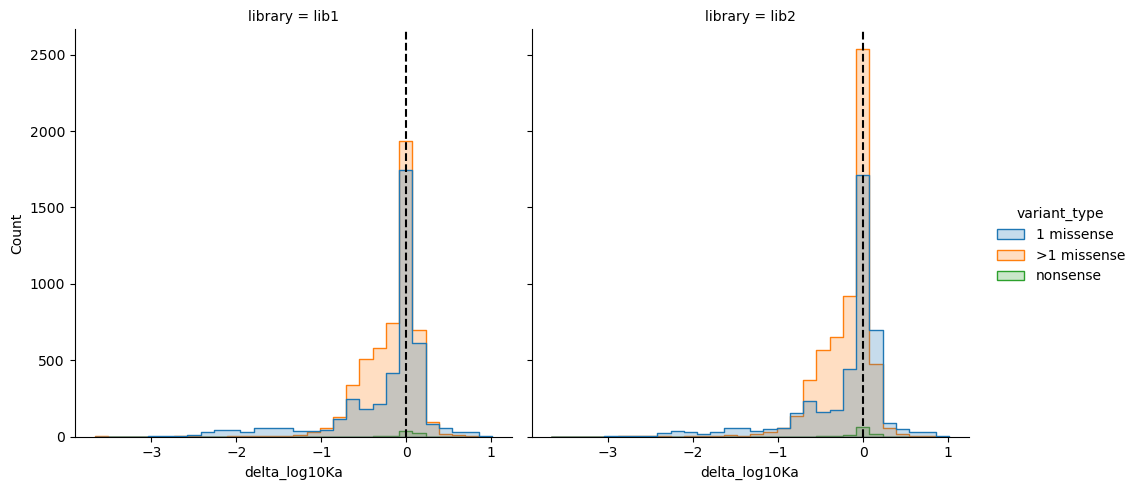

In [51]:
g = sns.displot(variant_params_df,
                x="delta_log10Ka", col="library", hue="variant_type",
                hue_order=("1 missense", ">1 missense", "nonsense"),
                bins=30,
                element="step"
                )
g.axes[0, 0].axvline(0, color="k", linestyle="--")
g.axes[0, 1].axvline(0, color="k", linestyle="--")
plt.show()

Show some titration curve fits

In [52]:
plot_variants = pd.Series([
                           "F225D",
                           "Y176T",
                           "V160D",
                           "I129H",
                           "Q16W",
                           "L4T",
                           ])
# plot_variants = pd.Series([
#                            "L4*",
#                            ])
plot_variants

0    F225D
1    Y176T
2    V160D
3    I129H
4     Q16W
5      L4T
dtype: object

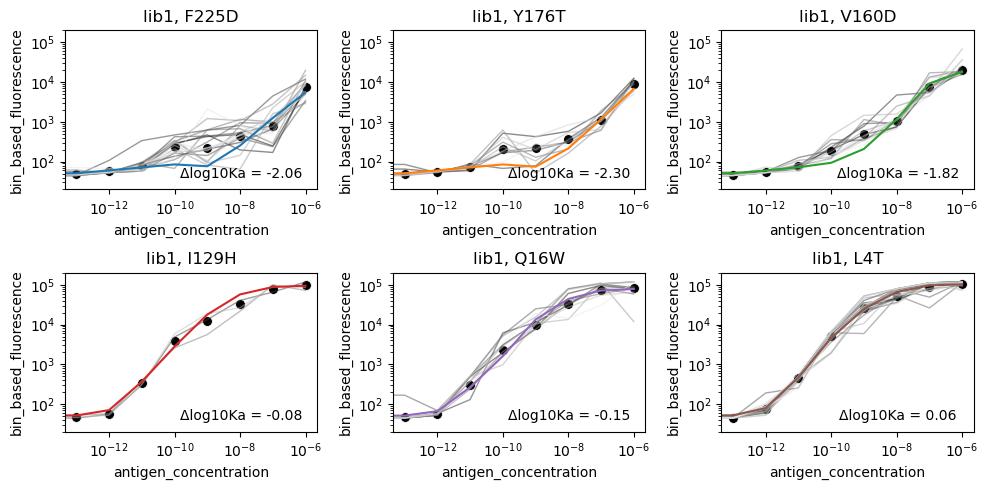

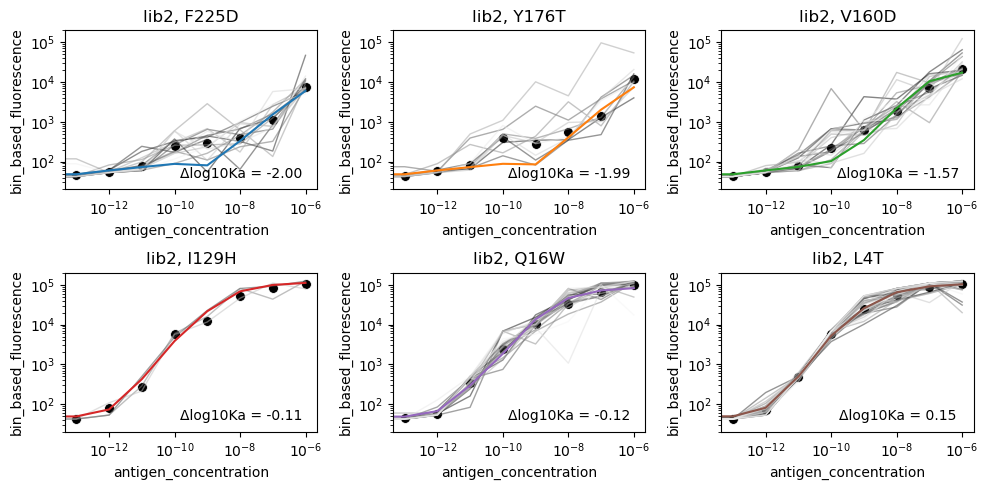

In [53]:
for library, params, data, lib_idxs in zip(
    ("lib1", "lib2"),
    (params1, params2),
    (data1, data2),
    (lib1_idxs, lib2_idxs),
    ):
    plt.figure(figsize=(10, 5))
    for i, variant in enumerate(plot_variants):
        plt.subplot(2, 3, i + 1)
        plt.title(f"{library}, {variant}")
        sns.lineplot(data=mean_bin_barcodes.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence", hue="barcode",
                    palette="gray", lw=1,
                    alpha=0.5,
                    legend=False,
                    )
        sns.scatterplot(data=mean_bin_variants.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence",
                    color="k", alpha=1.0,
                    s=50,
                    )
        plt.annotate(f"Δlog10Ka = {variant_params_df.query('(library == @library) & (variant == @variant)').delta_log10Ka.squeeze():.2f}",
                    xy=(0.7, 0.1), xycoords="axes fraction",
                    ha="center", va="center",
                    )
        variant_idx = list(variants[lib_idxs]).index(variant)
        ps = p(logx, params[1][variant_idx], data[6], params[2][variant_idx], b, params[3], params[4])
        if library == "lib1":
            binfs = binfs1
        elif library == "lib2":
            binfs = binfs2
        else:
            raise ValueError(library)
        mean_bins = np.exp((binfs * ps).sum(1) / ps.sum(1))
        plt.plot(x, mean_bins, color=f"C{i}")
        plt.ylim(20, 2e5)
        plt.xscale("log")
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

$\log_{10} K_A$ correlation

Number of variants: 15381


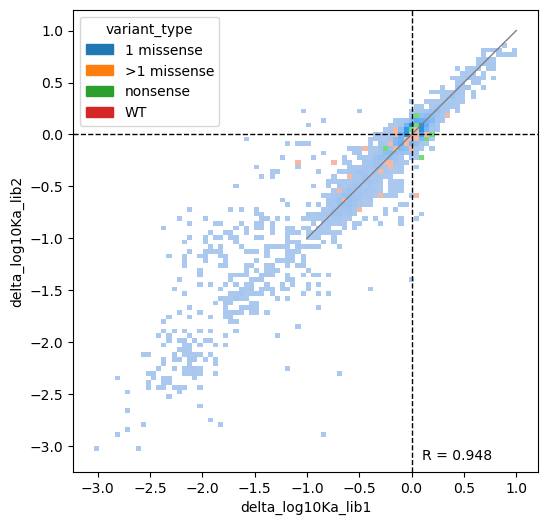

In [54]:
pivoted = variant_params_df.pivot(index="variant", columns="library")
print(f"Number of variants: {len(pivoted)}")
pivoted.columns = pivoted.columns.map("_".join)
pivoted.drop("variant_type_lib2", axis=1, inplace=True)
pivoted.rename(columns={"variant_type_lib1": "variant_type"}, inplace=True)
hist_bins = np.linspace(-2, 1, 100)
plt.figure(figsize=(6, 6))
sns.histplot(data=pivoted,
              x="delta_log10Ka_lib1",
              y="delta_log10Ka_lib2",
              hue="variant_type",
              # hue_order=("1 missense", ">1 missense", "nonsense"),
              )
pearson_cor_r = scipy.stats.pearsonr(*pivoted[['delta_log10Ka_lib1', 'delta_log10Ka_lib2']].dropna().values.T).statistic
plt.annotate(f"R = {pearson_cor_r:.3f}",
                (0.75, 0.05), xycoords="axes fraction", ha="left", va="top")
plt.plot([-1, 1], [-1, 1], color="gray", lw=1)
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
# plt.xlim(-2, 1)
# plt.ylim(-2, 1)
plt.show()

/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/jgallowa/miniconda3/envs/titeseq/lib/python3.12/site-packages/seaborn/axisgrid.py:1889: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


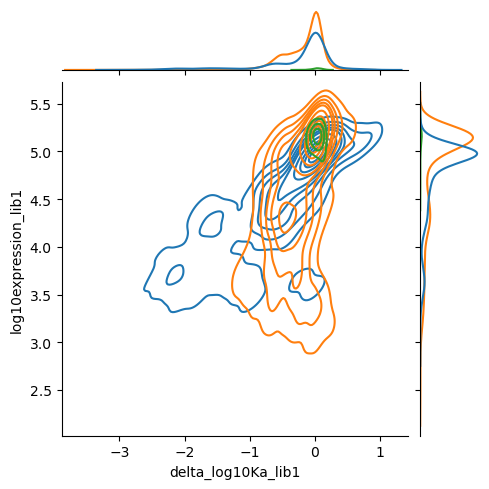

In [55]:
g = sns.jointplot(data=pivoted,
              x="delta_log10Ka_lib1",
              y="log10expression_lib1",
              hue="variant_type",
              # hue_order=("1 missense", ">1 missense", "nonsense"),
            #   joint_kws=dict(bins=(hist_bins, hist_bins)),
            #   marginal_kws=dict(bins=hist_bins),
              kind="kde",
              legend=False,
              height=5)
# sns.move_legend(g, loc="upper left")

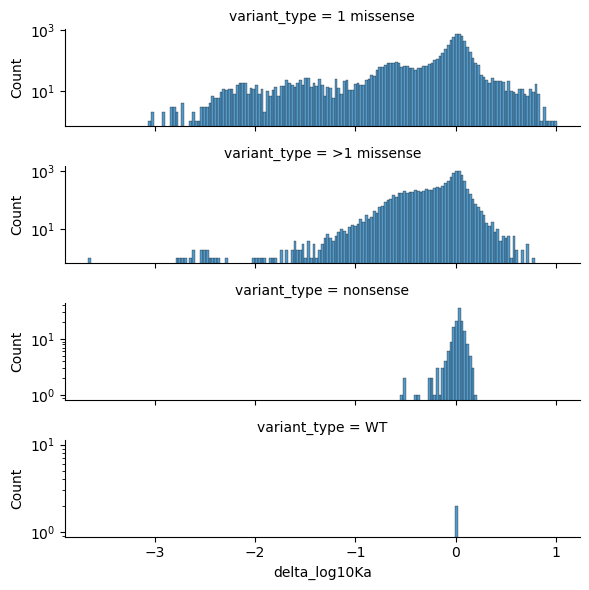

In [56]:
sns.displot(data=variant_params_df,
             x="delta_log10Ka", row="variant_type",
             multiple="stack",
            #  row_order=["WT", "1", "2", "3", "4", "nonsense"],
            #  bins=30,
             common_norm=False, facet_kws=dict(sharey=False),
             log=True,
             height=1.5, aspect=4)      

### IMGT numbering

In [57]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [58]:
def imgt_fn(variant):
    if variant == "WT":
        return "WT"
    muts = []
    for mut in variant.split(" "):
        wt = mut[0]
        site_scFv = int(mut[1:-1])
        site_imgt = pos_df.site[site_scFv]
        chain = pos_df.chain[site_scFv]
        mut = mut[-1]
        muts.append(f"{wt}{site_imgt}({chain}){mut}")
    return " ".join(muts)

In [59]:
variant_params_df["variant_imgt"] = variant_params_df.variant.apply(imgt_fn)
variant_params_df

,library,variant,n_aa_substitutions,variant_type,log10fraction,log10expression,log10Kd,delta_log10Ka,variant_imgt
0,lib1,A104C,1,1 missense,-3.634592,4.930475,-8.676313,0.073830,A120(H)C
1,lib1,A104C A173E,2,>1 missense,-5.218749,5.123374,-8.552676,-0.049806,A120(H)C A52(L)E
2,lib1,A104C F137L,2,>1 missense,-5.253717,5.229024,-8.626864,0.024382,A120(H)C F10(L)L
3,lib1,A104C G105V,2,>1 missense,-4.781183,4.391433,-7.912969,-0.689514,A120(H)C G121(H)V
4,lib1,A104C G118S,2,>1 missense,-5.207449,5.176415,-8.631564,0.029081,A120(H)C G<NA>(link)S
...,...,...,...,...,...,...,...,...,...
19574,lib2,Y94V,1,1 missense,-3.445384,5.005057,-9.171633,0.524733,Y103(H)V
19575,lib2,Y94V G113C,2,>1 missense,-4.769222,5.117825,-8.821000,0.174100,Y103(H)V G<NA>(link)C
19576,lib2,Y94V S112G,2,>1 missense,-4.990846,5.261665,-8.851406,0.204506,Y103(H)V S128(H)G
19577,lib2,Y94W,1,1 missense,-3.229448,4.827050,-8.541077,-0.105823,Y103(H)W


## Output

We take the mean affinity over libraries for each variant, and make a copy of the current `final_variant_scores` table with this revised entries for `bind_CGG` and `delta_bind_CGG` columns.

In [60]:
lib_avg = variant_params_df.groupby("variant_imgt").agg(
    dict(log10Kd=np.nanmean,
         delta_log10Ka=np.nanmean,
         )
    )
lib_avg.log10Kd = -lib_avg.log10Kd
lib_avg.rename(columns={"log10Kd": "bind_CGG",
                "delta_log10Ka": "delta_bind_CGG"},
                inplace=True)
lib_avg.index.name = "mutation"
lib_avg

/tmp/ipykernel_562/3862619948.py:1: FutureWarning: The provided callable <function nanmean at 0x7fe0bc4e9f80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  lib_avg = variant_params_df.groupby("variant_imgt").agg(
/tmp/ipykernel_562/3862619948.py:1: FutureWarning: The provided callable <function nanmean at 0x7fe0bc4e9f80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  lib_avg = variant_params_df.groupby("variant_imgt").agg(


,bind_CGG,delta_bind_CGG
mutation,,
A100(H)C,8.695843,0.071151
A100(H)C L53(L)Q,8.694009,0.047109
A100(H)D,7.875946,-0.748746
A100(H)D D107(H)Y,8.470593,-0.131890
A100(H)D G119(L)E,8.441015,-0.161468
...,...,...
Y88(H)W,8.643886,0.019194
Y88(H)W G36(L)Y,8.254521,-0.347962
Y88(H)W L124(L)M,8.558919,-0.087981


In [61]:
final_variant_scores = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv")
final_variant_scores

,target,wildtype,position,position_IMGT,chain,annotation,mutant,mutation,codon,single_nt,...,n_bc_bind_TuGG,n_libs_bind_TuGG,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr
0,CGG_naive,E,1,1.0,H,FWRH1,A,E1(H)A,GAG,True,...,19.0,2.0,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0
1,CGG_naive,E,1,1.0,H,FWRH1,C,E1(H)C,GAG,False,...,19.0,2.0,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0
2,CGG_naive,E,1,1.0,H,FWRH1,D,E1(H)D,GAG,True,...,15.0,2.0,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0
3,CGG_naive,E,1,1.0,H,FWRH1,E,E1(H)E,GAG,True,...,20086.0,2.0,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0
4,CGG_naive,E,1,1.0,H,FWRH1,F,E1(H)F,GAG,False,...,24.0,2.0,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,CGG_naive,NaN,121,NaN,link,NaN,S,NANA(link)S,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,CGG_naive,NaN,121,NaN,link,NaN,T,NANA(link)T,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4737,CGG_naive,NaN,121,NaN,link,NaN,V,NANA(link)V,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4738,CGG_naive,NaN,121,NaN,link,NaN,W,NANA(link)W,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
final_variant_scores = final_variant_scores.join(lib_avg, on="mutation", how="left", lsuffix="_old", rsuffix="")
final_variant_scores

,target,wildtype,position,position_IMGT,chain,annotation,mutant,mutation,codon,single_nt,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,bind_CGG,delta_bind_CGG
0,CGG_naive,E,1,1.0,H,FWRH1,A,E1(H)A,GAG,True,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,8.743405,0.118714
1,CGG_naive,E,1,1.0,H,FWRH1,C,E1(H)C,GAG,False,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,8.608719,-0.015972
2,CGG_naive,E,1,1.0,H,FWRH1,D,E1(H)D,GAG,True,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,8.636243,0.011552
3,CGG_naive,E,1,1.0,H,FWRH1,E,E1(H)E,GAG,True,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,NaN,NaN
4,CGG_naive,E,1,1.0,H,FWRH1,F,E1(H)F,GAG,False,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,8.758318,0.133627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,CGG_naive,NaN,121,NaN,link,NaN,S,NANA(link)S,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,CGG_naive,NaN,121,NaN,link,NaN,T,NANA(link)T,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4737,CGG_naive,NaN,121,NaN,link,NaN,V,NANA(link)V,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4738,CGG_naive,NaN,121,NaN,link,NaN,W,NANA(link)W,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


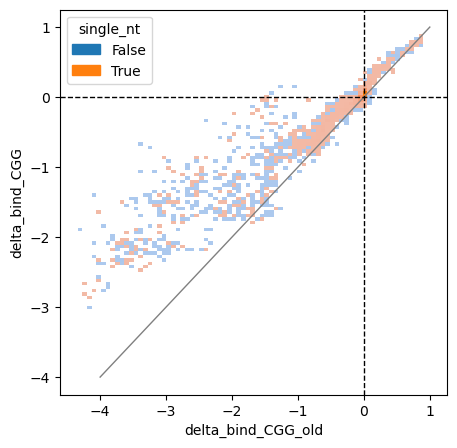

In [63]:
plt.figure(figsize=(5, 5))
sns.histplot(data=final_variant_scores,
              x="delta_bind_CGG_old",
              y="delta_bind_CGG",
              hue="single_nt",
              )
plt.plot([-4, 1], [-4, 1], color="gray", lw=1)
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
# plt.xlim(-2, 1)
# plt.ylim(-2, 1)
plt.show()

Number of single-mutant variants missing from new frame

In [64]:
(~final_variant_scores.delta_bind_CGG_old.isna() & final_variant_scores.single_nt & (final_variant_scores.wildtype != final_variant_scores.mutant) & final_variant_scores.delta_bind_CGG.isna()).sum()

0

In [65]:
final_variant_scores.drop(columns=["delta_bind_CGG_old"], inplace=True)

In [66]:
final_variant_scores.to_csv(f"{outdir}/final_variant_scores.csv", index=False)